In [1]:
%run ../setup_notebook.ipynb
import matplotlib.patches
import itertools

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "numba_utilities7.py", line 296:
@njit(signature0,parallel=True)
def erf_times_gauss_numba0(x):
^

  self.func_ir.loc))
/home/thijs/Desktop/RBM/test_profiler/rbm7/numba_utilities7.py:703: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights,V)/sum_weights
/home/thijs/Desktop/RBM/test_profiler/rbm7/numba_utilities7.py:862: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T,V)
/home/thijs/Desktop/RBM/test_profiler/rbm7/numba_utilities7.py:8

/home/thijs/repos/dnp-code/rbm_pipeline_functions.py


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /home/thijs/Desktop/20180912_Run01_spontaneous_rbm2.h5
Fraction not burst: 0.892670628489105


In [10]:
mom_names = {'means_v': '$< v_i >$', 'means_h': '$< h_\mu >$', 'pwcorr_vh': '$< v_i h_\mu >$',
             'pwcorr_vh_corr': '$< v_i h_\mu >$', 'reconstruct': 'LLH index of reconstruction',
              'pwcorr_vv': '$< v_i v_j >$', 'pwcorr_hh': r'$< h_\mu h_\nu >$', 
            'pwcorr_vv_corr': '$< v_i v_j > - < v_i> <v_j >$', 
             'pwcorr_hh_corr': r'$< h_\mu h_\nu > - < h_\mu> <h_\nu >$'}
mom_colors = {'means_v': 'blue', 'means_h': 'red', 'pwcorr_vh': 'orange',
              'pwcorr_vv': 'green', 'pwcorr_hh': 'purple', 'recon_llh': 'grey'}
for xx in ['pwcorr_vv', 'pwcorr_hh', 'pwcorr_vh']:
    mom_colors[xx + '_corr'] = mom_colors[xx]

In [7]:
def plot_binned_stats(ax, plot_bins, mean_bins, std_bins, comp_moment=None):
    if comp_moment is not None:
        plot_color = mom_colors[comp_moment]
    else:
        plot_color = 'grey'
    std_se = 'std'
    inds_nn = ~np.isnan(mean_bins)
    plot_bins, mean_bins, std_bins = plot_bins[inds_nn], mean_bins[inds_nn], std_bins[inds_nn]
    
    ax.plot([plot_bins.min(), plot_bins.max()], [plot_bins.min(), plot_bins.max()], ':', color='k', label='y=x')
    ax.plot(plot_bins, mean_bins, color=plot_color, label='mean')
    ax.fill_between(plot_bins, mean_bins, mean_bins+std_bins, color=plot_color, alpha=0.3, label=std_se)
    ax.fill_between(plot_bins, mean_bins, mean_bins-std_bins, color=plot_color, alpha=0.3)
    ax.set_xlim([plot_bins.min(), plot_bins.max()])
    ax.set_ylim([plot_bins.min(), plot_bins.max()])
    return ax



def bin_stats(stat_r, stat_g, n_bins=100):
    result = pf.pearsonr_ci(stat_r, stat_g)
    r_bins = np.linspace(np.percentile(stat_r, 1), np.percentile(stat_r, 99), n_bins + 1)
    mean_g_bins = np.zeros(n_bins)
    std_g_bins = np.zeros(n_bins)
    for i in range(n_bins):
        inds = np.logical_and((stat_r <= r_bins[i+1]), (stat_r > r_bins[i]))
        mean_g_bins[i] = np.mean(stat_g[inds])
        std_g_bins[i] = np.std(stat_g[inds])
    plot_bins = 0.5 * (r_bins[1:] + r_bins[:-1])
    return result, (plot_bins, mean_g_bins, std_g_bins)

# Tables

- Load pre-computed tables.

- Plot tables per metric

In [53]:
df_folder = '/home/thijs/repos/dnp-code/results_df_lookup/'
df_names = ['df_lookup__burstsTrue_testtest_correctpwvvTrue_trainconfig_2020-03-04__20180912-Run01.h5']


# df_names = ['df_lookup__burstsTrue_testtest_correctpwvvTrue_2020-02-11__20180912-Run01.h5']
# df_names = ['df_lookup__burstsTrue_testtest_correctpwvvFalse_2020-02-22__20180912-Run01.h5',
#             'df_lookup__burstsTrue_testtest_correctpwvvFalse_2020-02-15__20180912-Run01.h5']
# df_names = ['df_lookup__burstsFalse_testtest_correctpwvvFalse_2020-02-24__20180912-Run01.h5',
#             'df_lookup__burstsFalse_testtest_correctpwvvFalse_0_2020-02-24__20180912-Run01.h5']

In [54]:
# df_lookup_dict = {ii: pd.read_hdf(x) for ii, x in enumerate(df_names)}
# df_lookup_2 = pd.read_hdf('/home/thijs/repos/dnp-code/results_df_lookup/df_lookup__burstsTrue_testtest_2020-02-22__20180912-Run01.h5')
# assert (df_lookup_1.columns == df_lookup_2.columns).all()

df_lookup = pd.concat([pd.read_hdf(df_folder + x) for x in df_names])
df_lookup = df_lookup[df_lookup.l1 != 0.001]

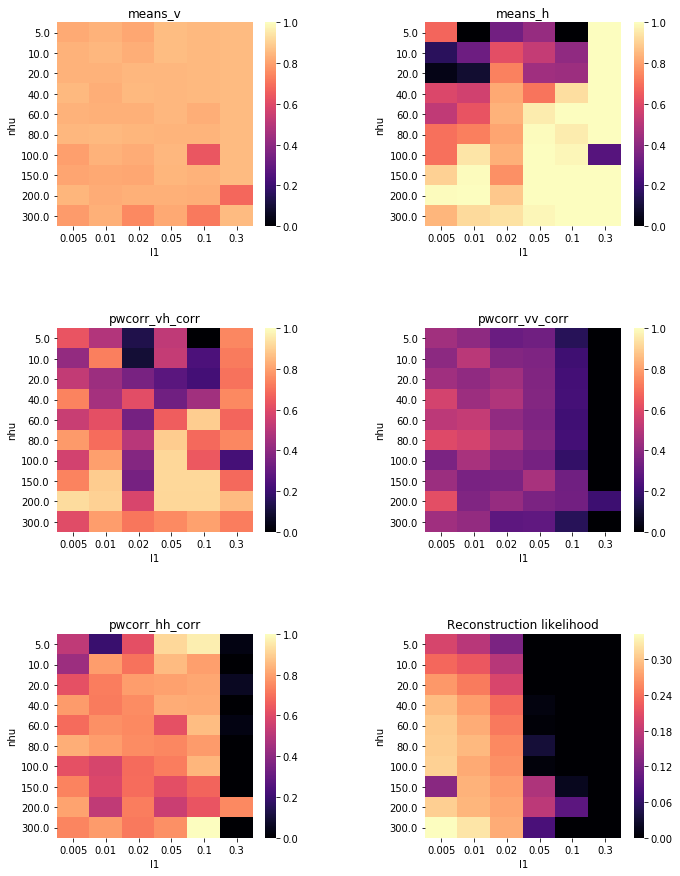

In [55]:
plt.rcParams['figure.figsize'] = (11, 15)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

list_comp_moms = ['means_v', 'means_h', 'pwcorr_vh_corr', 'pwcorr_vv_corr', 'pwcorr_hh_corr']

ax_hm = {}
for iplot, stat in enumerate(list_comp_moms):
    plt.subplot(3, 2, iplot+1)
    ax_hm[iplot] = sns.heatmap(pd.pivot_table(df_lookup, values=stat, 
                               index='nhu', columns='l1'), 
                vmin=0, vmax=1, 
                cmap='magma')
    b, t = ax_hm[iplot].get_ylim() # correct for default cut off
    b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
    t -= 0.5 # 
    plt.ylim(b, t) # u
    plt.title(stat)

plt.subplot(3, 2, 6)
llh_table = pd.pivot_table(df_lookup, values='reconstruct_med', 
                           index='nhu', columns='l1')
ax_hm['llh'] = sns.heatmap(llh_table, #vmin=np.nanmin(llh_table[llh_table != 0]), 
            vmax=np.nanmax(llh_table[llh_table != 0]),
            vmin=0, cmap='magma');
b, t = ax_hm['llh'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
plt.ylim(b, t) # u
plt.title('Reconstruction likelihood');

In [56]:
stat_mat = {}
for iplot, stat in enumerate(list_comp_moms + ['reconstruct_med']):
    stat_mat[stat] = pd.pivot_table(df_lookup, values=stat, index='nhu', columns='l1')
min_proj = stat_mat[list_comp_moms[0]]
for stat in list_comp_moms[1:]:
    min_proj = min_proj.combine(stat_mat[stat], np.minimum)
    
norm_llh_table = llh_table #(llh_table[llh_table != 0] - np.nanmin(llh_table[llh_table != 0]))
norm_llh_table = norm_llh_table / np.nanmax(norm_llh_table)
min_proj = min_proj.combine(norm_llh_table, np.minimum)

Text(0.5, 1, 'Elementwise minimum of all 6 conditions')

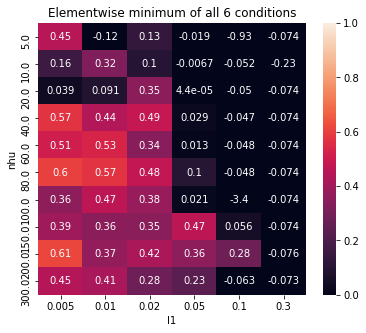

In [57]:
plt.rcParams['figure.figsize'] = (6, 5)
summ_hm = sns.heatmap(min_proj, vmin=0, vmax=1, annot=True)
b, t = summ_hm.get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
plt.ylim(b, t) # update the ylim(bottom, top) values
# summ_hm.set_yticklabels(rotation=90)
plt.title('Elementwise minimum of all 6 conditions')

# Load binned stats

In [58]:
binned_stats_dict = {}
for fn in df_names:

    binned_stats_name = (df_folder + 'binned_stats_dict__' + 
                         fn.lstrip('df_lookup').rstrip('h5') + 'pkl')

    binned_stats_dict = {**binned_stats_dict, **pickle.load(open(binned_stats_name, 'rb'))}
print(binned_stats_dict['settings'].keys())
## Info
# The value of a dict entry binned_stats_dict[ts_rbm][mom] 
# is (plot_bins, mean_g_bins, std_g_bins)

dict_keys(['correct_vv_pwcorr', 'correct_hh_pwcorr', 'correct_vh_pwcorr', 'use_bursts', 'descr_traintest', 'multiple_rbm_path', 'mom_pearson', 'include_nan_rbms', 'nv_threshold_moments', 'data_set', 'data_path'])


# PLOT full fig

In [116]:
arg_nhu, arg_l1 = np.where(min_proj == min_proj.max().max())
arg_nhu, arg_l1 = arg_nhu[0], arg_l1[0]
max_nhu = min_proj.iloc[arg_nhu, :].name
max_l1 = min_proj.iloc[:, arg_l1].name


arg_nhu_shown = arg_nhu
arg_l1_shown = arg_l1
nhu_shown = max_nhu
l1_shown = max_l1


In [134]:

save_fig = True
current_datetime = str(datetime.datetime.now())[:10] + '_' + str(datetime.datetime.now())[11:13] + '-' + str(datetime.datetime.now())[14:16]
save_folder = '/home/thijs/repos/zf-rbm/Figures/pdfs/'
if 'trainconfig' in df_names[0].split('_'):
    name_config = 'Train'
else:
    name_config = 'Random'
name_fig = (f'fig_model-selection_' + f'{df_names[0].split("_")[3]}_{df_names[0].split("_")[4]}_{df_names[0].split("_")[5]}_' + 
            f'init{name_config}_{current_datetime}.pdf') 

In [135]:
ts_rbm = df_lookup[np.logical_and(df_lookup.l1 == l1_shown, df_lookup.nhu == nhu_shown)].timestamp.values[0]
print(ts_rbm)

2019-08-17-0207


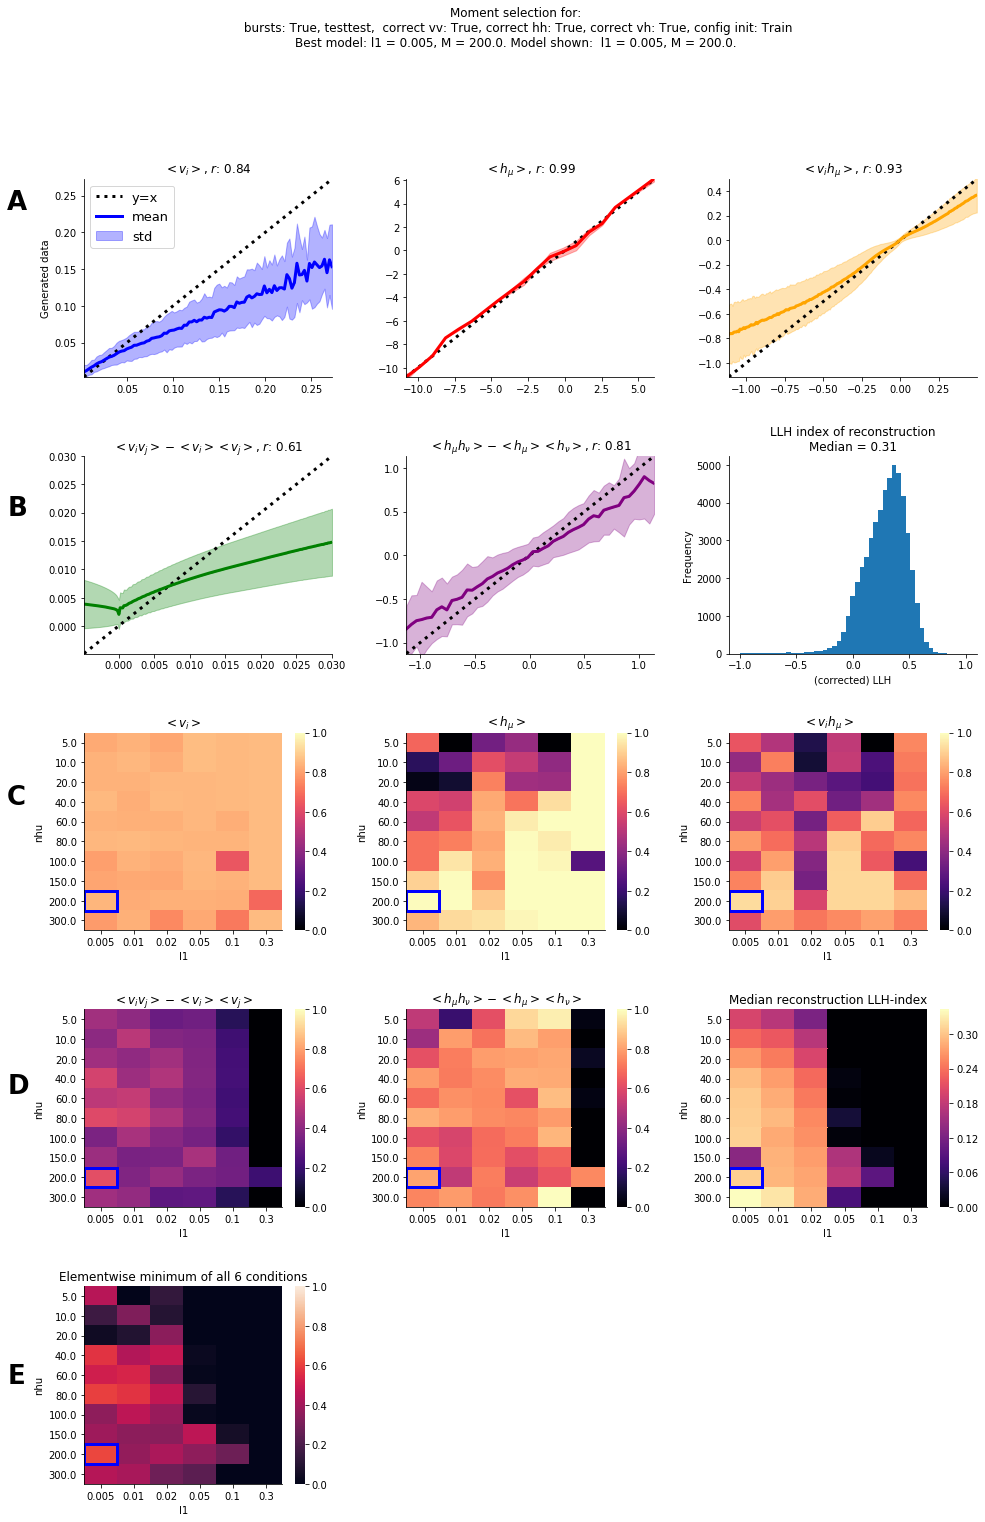

In [136]:
plt.rcParams['figure.figsize'] = (16, 24)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

assert ts_rbm in binned_stats_dict.keys()
indiv_ax = {}
sum_ax = {}



for i_plot, comp_moment in enumerate(list_comp_moms):
    indiv_ax[comp_moment] = plt.subplot(5, 3, int(i_plot + 1))
    plot_bins = binned_stats_dict[ts_rbm][comp_moment][0]
    mean_bins = binned_stats_dict[ts_rbm][comp_moment][1]
    std_bins = binned_stats_dict[ts_rbm][comp_moment][2]
    ro = df_lookup[df_lookup.timestamp == ts_rbm][comp_moment].values[0]
    indiv_ax[comp_moment] = plot_binned_stats(indiv_ax[comp_moment], plot_bins, mean_bins,
                                             std_bins, comp_moment)
    
    
    sum_ax[comp_moment] = plt.subplot(5, 3, int(i_plot + 7))
    sum_ax[comp_moment] = sns.heatmap(pd.pivot_table(df_lookup, values=comp_moment, 
                               index='nhu', columns='l1'), 
                vmin=0, vmax=1, 
                cmap='magma')
    b, t = sum_ax[comp_moment].get_ylim() # correct for default cut off
    b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
    t -= 0.5 # 
    sum_ax[comp_moment].set_ylim(b, t) # u
    sum_ax[comp_moment].set_title(r'{}'.format(mom_names[comp_moment]))
    sum_ax[comp_moment].add_patch(matplotlib.patches.Rectangle((arg_l1_shown, arg_nhu_shown), 1, 1, 
                                                               fill=False, edgecolor='blue', lw=3))
    if i_plot == 0:
        indiv_ax[comp_moment].set_ylabel('Generated data');
        yscale = indiv_ax[comp_moment].get_ylim()[1] * 0.85
        indiv_ax[comp_moment].text(s='A', x=-0.08, y=yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='B', x=-0.08, y=-0.8 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='C', x=-0.08, y=-2.5 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='D', x=-0.08, y=-4.2 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='E', x=-0.08, y=-5.9 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].legend(prop={'size':13}, loc='upper left')

    indiv_ax[comp_moment].set_title(r'{}, $r$: '.format(mom_names[comp_moment]) +f'{str(np.round(ro, 2))}');

indiv_ax['reconstruct'] = plt.subplot(5, 3, 6)
plt.hist(binned_stats_dict[ts_rbm]['reconstruct'], bins=np.linspace(-1, 1, 50))
indiv_ax['reconstruct'].set_title(mom_names['reconstruct'] + f'\nMedian = {np.round(df_lookup[df_lookup.timestamp == ts_rbm]["reconstruct_med"].values[0], 2)}')
indiv_ax['reconstruct'].set_xlabel('(corrected) LLH'); indiv_ax['reconstruct'].set_ylabel('Frequency')
    
sum_ax['llh'] = plt.subplot(5, 3, 12)
llh_table = pd.pivot_table(df_lookup, values='reconstruct_med', 
                           index='nhu', columns='l1')
sum_ax['llh'] = sns.heatmap(llh_table, #vmin=np.nanmin(llh_table[llh_table != 0]), 
            vmax=np.nanmax(llh_table[llh_table != 0]),
            vmin=0, cmap='magma');
b, t = sum_ax['llh'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
sum_ax['llh'].set_ylim(b, t) # u
sum_ax['llh'].set_title('Median reconstruction LLH-index');
sum_ax['llh'].add_patch(matplotlib.patches.Rectangle((arg_l1, arg_nhu), 1, 1, 
                                                               fill=False, edgecolor='blue', lw=3))

sum_ax['aggr'] = plt.subplot(5, 3, 13)
sum_ax['aggr'] = sns.heatmap(min_proj, vmin=0, vmax=1, annot=False)
b, t = sum_ax['aggr'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
sum_ax['aggr'].set_ylim(b, t) # update the ylim(bottom, top) values
# summ_hm.set_yticklabels(rotation=90)
sum_ax['aggr'].set_title('Elementwise minimum of all 6 conditions')
sum_ax['aggr'].add_patch(matplotlib.patches.Rectangle((arg_l1_shown, arg_nhu_shown), 1, 1, 
                                                               fill=False, edgecolor='blue', lw=3))
    
if 'settings' in binned_stats_dict.keys():
    opt_str_settings = f'bursts: {binned_stats_dict["settings"]["use_bursts"]}, {binned_stats_dict["settings"]["descr_traintest"]},  correct vv: {binned_stats_dict["settings"]["correct_vv_pwcorr"]}, correct hh: {binned_stats_dict["settings"]["correct_hh_pwcorr"]}, correct vh: {binned_stats_dict["settings"]["correct_vh_pwcorr"]}'
else:
    opt_str_settings = f'{df_names[0].split("_")[3]}, {df_names[0].split("_")[4]}, {df_names[0].split("_")[5]}'
plt.suptitle(f'Moment selection for:' +
            '\n ' + opt_str_settings + f', config init: {name_config}'
            f'\nBest model: l1 = {max_l1}, M = {max_nhu}. Model shown:  l1 = {l1_shown}, M = {nhu_shown}.')
sns.despine()
if save_fig:
    plt.savefig(save_folder + name_fig)

In [98]:
binned_stats_dict['settings']

{'correct_vv_pwcorr': True,
 'correct_hh_pwcorr': True,
 'correct_vh_pwcorr': True,
 'use_bursts': True,
 'descr_traintest': 'testtest',
 'multiple_rbm_path': '/home/thijs/Desktop/RBM/For_Thijs/may_profiler/',
 'mom_pearson': 'moment',
 'include_nan_rbms': False,
 'nv_threshold_moments': 150000,
 'data_set': '20180912-Run01',
 'data_path': '20180912_Run01_spontaneous_rbm2.h5'}

## Train test difference:

In [2]:
print(train_data['wb'].shape, test_data['wb'].shape)

(52518, 4000) (52518, 1553)


In [5]:
# result, (plot_bins, mean_g_bins, std_g_bins) = bin_stats(pwcorr_vv_test.reshape(-1), 
#                                                          pwcorr_vv_train.reshape(-1))

# means_train = np.mean(train_data['wb'], 1)
# means_test = np.mean(test_data['wb'], 1)

# subsamp = np.random.choice(a=52000, size=10000, replace=False)
# pwcorr_vv_train = np.corrcoef(train_data['wb'][subsamp, :]).astype('float32')
# pwcorr_vv_test = np.corrcoef(test_data['wb'][subsamp, :]).astype('float32')
# print(pwcorr_vv_train.shape)


In [18]:
dict_path = '/home/thijs/repos/dnp-code/results_df_lookup/'
dict_name = 'train_test_stats__time4000_split.pkl'
dict_tt_stats = pickle.load(open(dict_path + dict_name, 'rb'))

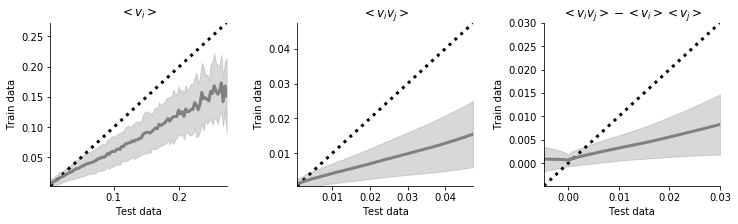

In [19]:
plt.rcParams['figure.figsize'] = (12, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ff = {}
for i_loop, comp_moment in enumerate(['means_v', 'pwcorr_vv', 'pwcorr_vv_corr']):
    dd = dict_tt_stats[comp_moment]
    ff[i_loop] = plt.subplot(1, 3, i_loop + 1)
    plot_binned_stats(ff[i_loop], dd['plot_bins'], dd['means_bins'], dd['std_bins'])
    ff[i_loop].set_title(r'{}'.format(mom_names[comp_moment]))
    ff[i_loop].set_xlabel('Test data'); ff[i_loop].set_ylabel('Train data')
    
sns.despine()

In [63]:
dict_tt_stats['means_v']['correlation']

0.942829663059138

In [ ]:
# all_shuffled_time_inds = np.random.permutation(full_data['wb'].shape[1])
all_time_inds = np.arange(full_data['wb'].shape[1])
n_seg = 10
n_perseg = int(np.floor(full_data['wb'].shape[1] / n_seg))
inds_seg = {}
for seg in range(n_seg):
    if seg < (n_seg - 1):
        inds_seg[seg] = all_time_inds[(n_perseg * seg):(n_perseg * (seg + 1))]
    else:  # final one

        inds_seg[seg] = all_time_inds[(n_perseg * seg):]  # take last few
    print(f'segment {seg}, size {len(inds_seg[seg])}')

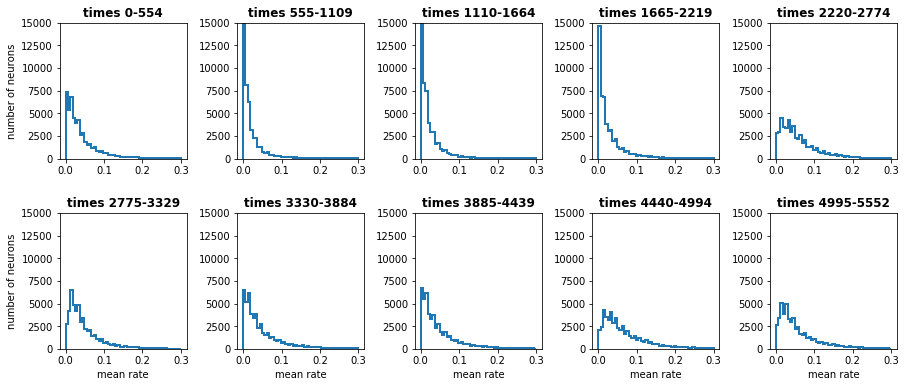

In [153]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ff = {}

for seg in range(n_seg):
    means_train = np.mean(full_data['wb'][:, inds_seg[seg]], 1)
#     means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
#     ro, (plot_bins, means_bins, std_bins) = bin_stats(means_test, means_train)
#     print(ro[0])
    ff[seg] = plt.subplot(2, 5, seg + 1)
#     plot_binned_stats(ff[seg], plot_bins, means_bins, std_bins)
    ff[seg].hist(means_train, bins=np.linspace(0, 0.3, 50), histtype='step', linewidth=2)
    ff[seg].set_title(f'times {inds_seg[seg][0]}-{inds_seg[seg][-1]}', weight='bold')
    ff[seg].set_ylim([0, 15000])
for seg in [0, 5]:
    ff[seg].set_ylabel('number of neurons')
for seg in np.arange(5, 10):
    ff[seg].set_xlabel('mean rate');

In [196]:
n_combs = 0
for comb, test_segs in enumerate(itertools.combinations(np.arange(n_seg), 3)):
    n_combs += 1
print(f'Number of combinations is {n_combs}')

df_combs_mean_stats = pd.DataFrame({x: np.zeros(n_combs) for x in ['test_segs', 
                                    'train_segs' ,'pearson', 'lr_slope', 'lr_intercept']})
df_combs_mean_stats = df_combs_mean_stats.astype('object')


# ff = {}
for comb, test_segs in tqdm(enumerate(itertools.combinations(np.arange(n_seg), 3))):  # iterate through unique combinations
#     test_segs = np.random.choice(a=n_seg, size=3, replace=False)
    test_segs = np.array(list(test_segs))
    train_segs = np.array(list(set(np.arange(n_seg)).difference(set(test_segs)))) # train is difference of test set
#     print(train_segs, test_segs)
    df_combs_mean_stats['train_segs'].iat[comb] = train_segs
    df_combs_mean_stats['test_segs'].iat[comb] = test_segs
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
        
    means_train = np.mean(full_data['wb'][:, new_train_inds], 1)  # compute means
    means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
    ro, (plot_bins, means_bins, std_bins) = bin_stats(means_test, means_train)  # compute corr
#     print(ro[0])
    df_combs_mean_stats['pearson'].iat[comb] = ro[0]
    inds_nn = ~np.isnan(means_bins)
    assert len(inds_nn) == len(means_bins)  # no nans here right?
    plot_bins, means_bins, std_bins = plot_bins[inds_nn], means_bins[inds_nn], std_bins[inds_nn]
    lr = sklearn.linear_model.LinearRegression().fit(plot_bins[:, np.newaxis], means_bins)  # find lin reg to find slope and intercept
#     print(lr.intercept_, lr.coef_)
    df_combs_mean_stats['lr_slope'].iat[comb] = lr.coef_[0]
    df_combs_mean_stats['lr_intercept'].iat[comb] = lr.intercept_
    
#     ff[comb] = plt.subplot(2, 5, comb + 1)
#     plot_binned_stats(ff[comb], plot_bins, means_bins, std_bins)


0it [00:00, ?it/s]

Number of combinations is 120



1it [00:01,  1.01s/it]
2it [00:01,  1.01it/s]
3it [00:02,  1.02it/s]
4it [00:03,  1.02it/s]
5it [00:04,  1.03it/s]
6it [00:05,  1.04it/s]
7it [00:06,  1.04it/s]
8it [00:07,  1.04it/s]
9it [00:08,  1.04it/s]
10it [00:09,  1.05it/s]
11it [00:10,  1.05it/s]
12it [00:11,  1.06it/s]
13it [00:12,  1.06it/s]
14it [00:13,  1.06it/s]
15it [00:14,  1.06it/s]
16it [00:15,  1.06it/s]
17it [00:16,  1.06it/s]
18it [00:17,  1.06it/s]
19it [00:18,  1.06it/s]
20it [00:19,  1.06it/s]
21it [00:19,  1.06it/s]
22it [00:20,  1.05it/s]
23it [00:21,  1.06it/s]
24it [00:22,  1.08it/s]
25it [00:23,  1.09it/s]
26it [00:24,  1.10it/s]
27it [00:25,  1.07it/s]
28it [00:26,  1.07it/s]
29it [00:27,  1.07it/s]
30it [00:28,  1.07it/s]
31it [00:29,  1.07it/s]
32it [00:30,  1.07it/s]
33it [00:31,  1.06it/s]
34it [00:32,  1.06it/s]
35it [00:33,  1.06it/s]
36it [00:33,  1.07it/s]
37it [00:34,  1.08it/s]
38it [00:35,  1.09it/s]
39it [00:36,  1.10it/s]
40it [00:37,  1.11it/s]
41it [00:38,  1.12it/s]
42it [00:39,  1.12it/s]


(0.95, 1.05)

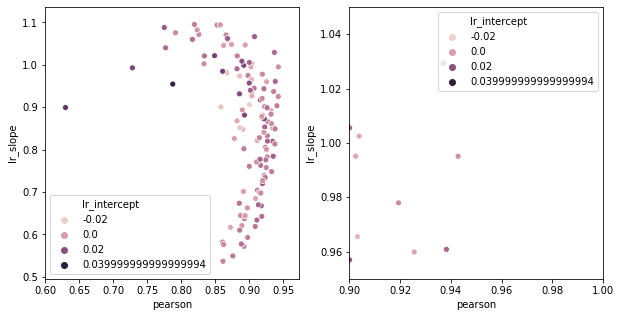

In [212]:
plt.rcParams['figure.figsize'] = (10, 5)

plt.subplot(121)
sns.scatterplot(data=df_combs_mean_stats, x='pearson', y='lr_slope', hue='lr_intercept')


plt.subplot(122)
sns.scatterplot(data=df_combs_mean_stats, x='pearson', y='lr_slope', hue='lr_intercept')

plt.xlim([0.9, 1])
plt.ylim([0.95, 1.05])

In [220]:
comb_list = np.where(np.logical_and(np.abs(df_combs_mean_stats['lr_slope'] - 1) < 0.05,
               df_combs_mean_stats['pearson'] > 0.9))[0]

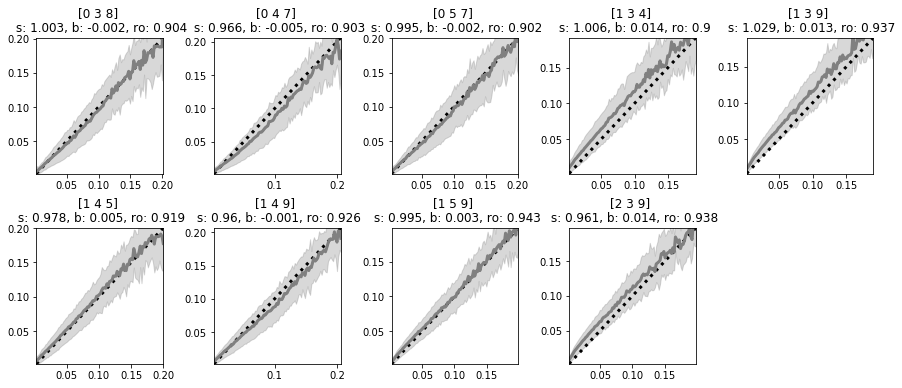

In [227]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i_loop, comb in enumerate(comb_list):
    train_segs = df_combs_mean_stats['train_segs'].iat[comb]
    test_segs = df_combs_mean_stats['test_segs'].iat[comb]
#     print(train_segs, test_segs)
 
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
        
    means_train = np.mean(full_data['wb'][:, new_train_inds], 1)  # compute means
    means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
    ro, (plot_bins, means_bins, std_bins) = bin_stats(means_test, means_train)  # compute corr
#     print(ro[0])
    df_combs_mean_stats['pearson'].iat[comb] = ro[0]
    inds_nn = ~np.isnan(means_bins)
    assert len(inds_nn) == len(means_bins)  # no nans here right?
    plot_bins, means_bins, std_bins = plot_bins[inds_nn], means_bins[inds_nn], std_bins[inds_nn]
#     print(df_combs_mean_stats['lr_slope'].iat[comb], 
#           df_combs_mean_stats['lr_intercept'].iat[comb], 
#           df_combs_mean_stats['pearson'].iat[comb])
    
    ff[comb] = plt.subplot(2, 5, i_loop + 1)
    plot_binned_stats(ff[comb], plot_bins, means_bins, std_bins)
    ff[comb].set_title(f'{test_segs} \n s: {np.round(df_combs_mean_stats["lr_slope"].iat[comb], 3)}, b: {np.round(df_combs_mean_stats["lr_intercept"].iat[comb], 3)}, ro: {np.round(df_combs_mean_stats["pearson"].iat[comb], 3)}')

In [235]:
def export_inds(test_segs=[0], save_file=True, file_name=None, save_folder=str()):
    """Function to export time indices corresponding to test_segs"""

    if file_name is None:
        test_str = ''.join([str(x) for x in test_segs])
        file_name = f'train_test_inds__test_segs_{test_str}_nseg{n_seg}.pkl'
    train_segs = np.array(list(set(np.arange(n_seg)).difference(set(test_segs)))) # train is difference of test set
#     print(train_segs, test_segs)
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
    dd = {'train_segs': train_segs, 'test_segs': test_segs,
          'train_inds': new_train_inds, 'test_inds': new_test_inds}
    
    if save_file:
        ff = open(save_folder + file_name, 'wb')
        pickle.dump(dd, ff)
    return dd

In [240]:
export_inds(test_segs=[1, 5, 9], save_file=True, save_folder='/home/thijs/repos/dnp-code/train_test_inds/')

{'train_segs': array([0, 2, 3, 4, 6, 7, 8]),
 'test_segs': [1, 5, 9],
 'train_inds': array([   0,    1,    2, ..., 4992, 4993, 4994]),
 'test_inds': array([ 555,  556,  557, ..., 5550, 5551, 5552])}

In [47]:
tmp = np.random.randn(100000000).astype('float32')
tmp1 = np.random.randn(100000000).astype('float32')

In [49]:
tmp_m = sklearn.linear_model.LinearRegression().fit(tmp[:, np.newaxis], tmp1)
tmp_m.coef_

array([-0.00016526], dtype=float32)

In [51]:
tmp_h = np.histogram2d(tmp, tmp1)

In [53]:
len(tmp_h)

3